[Run Online](https://jupyterhub.uni-muenster.de/hub/user-redirect/git-pull?repo=https%3A%2F%2Fzivgitlab.uni-muenster.de%2Fai-systems%2Fteaching%2Fpublic%2Fws-25%2Feinfuehrung-neuronale-netze&urlpath=lab%2Ftree%2Feinfuehrung-neuronale-netze%2F02+Linear+Regression%2F02.ipynb&branch=main)

# Regression with Linear Model

## Notation

We denote vectors with lowercase letters and matrices with uppercase letters.
Examples:

- $x$ usually refers to a vector of $m$ scalar datapoints $[x_1, \dots, x_m]^T$ (same for $y$)
- $X$ usually refers to a vector of $m$ multi-dimensional datapoints, hence, a matrix

In [1]:
from IPython.display import IFrame

IFrame("https://www.uni-muenster.de/AISystems/courses/drl/nn/02_Regression/02-regression-deck.html#/task-2.1-and-2.2---learning-a-linear-model", width="100%", height="600")

## Data

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset
data = [
    {"size": 50, "price": 450, "rooms": 2, "distance_to_center": 5, "district": "Gievenbeck"},
    {"size": 25, "price": 500, "rooms": 1, "distance_to_center": 3.5, "district": "Sentrup"},
    {"size": 35, "price": 770, "rooms": 1, "distance_to_center": 3, "district": "Wienburg"},
    {"size": 80, "price": 800, "rooms": 3, "distance_to_center": 8, "district": "Nienberge"},
    {"size": 62, "price": 800, "rooms": 2, "distance_to_center": 5, "district": "Coerde"},
    {"size": 70, "price": 820, "rooms": 3, "distance_to_center": 4.5, "district": "Gievenbeck"},
    {"size": 19, "price": 440, "rooms": 1, "distance_to_center": 7, "district": "Nienberge"},
    {"size": 73, "price": 1127, "rooms": 3.5, "distance_to_center": 5, "district": "Wienburg"},
    {"size": 20, "price": 769, "rooms": 1, "distance_to_center": 1, "district": "Zentrum"},
]

# Extract regressors and regressands
sizes = np.array([apt['size'] for apt in data], dtype=float)
distances = np.array([apt['distance_to_center'] for apt in data], dtype=float)
prices = np.array([apt['price'] for apt in data], dtype=float)
rooms = np.array([apt['rooms'] for apt in data], dtype=float)

# Feature matrix: we usually process inputs as a matrix, even if a single input is only of dimension 1
x = sizes
print(x.shape)  # (n_samples,)  # this is usually not preferred
X = sizes.reshape(-1, 1)
print(X.shape)  # (n_samples, 1)
X = np.column_stack((sizes,))
print(X.shape)  # (n_samples, 1)
X = np.column_stack((sizes, distances))
print(X.shape)  # (n_samples, 2)

(9,)
(9, 1)
(9, 1)
(9, 2)


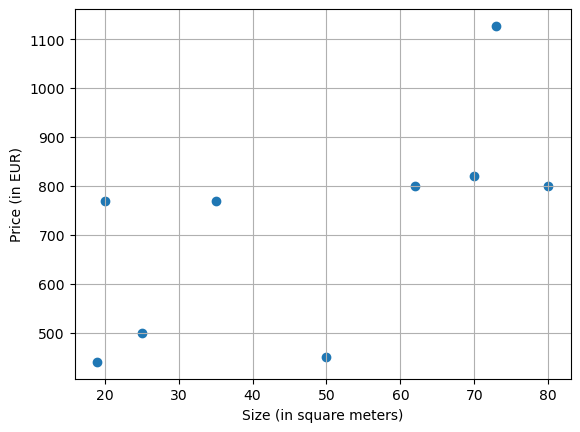

In [3]:
# Visualize apartment price vs size
%matplotlib inline

plt.close()
plt.scatter(x=sizes, y=prices)
plt.xlabel('Size (in square meters)')
plt.ylabel('Price (in EUR)')
plt.grid(True)
plt.show()

## Mean Squared Error
Linear Regression minimizes the mean squared error (MSE):
$$
\begin{aligned}
E(w) &= \frac{1}{m}\sum^m_{i=1}(y^{(i)}-f(x^{(i)},w))^2\\
&= \frac{1}{m}\lVert y-f(X,w)\rVert_2^2
\end{aligned}
$$
Note:
- as part of a minimization problem, we might omit the $\frac{1}{m}$ factor

In [4]:
def mean_squared_error(y_true, y_pred, verbose=True):
    """
    Calculate the Mean Squared Error between the actual and predicted values.

    Parameters:
    - y_true: array-like, actual values (ground truth)
    - y_pred: array-like, predicted values
    """
    # Ensure inputs are NumPy arrays for element-wise operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the squared differences
    squared_differences = (y_true - y_pred) ** 2

    # Return the mean of the squared differences
    mse = np.mean(squared_differences)
    if verbose:
        print(f"MSE: {mse: ,.1f}")

    return mse

## Linear Regression
### Linear Function Approximator
Linear regression optimizes parameters $b\in\mathbb{R}, w\in\mathbb{R}^{d-1}$ of a linear model
$$
f(x^{(i)}, w) := \langle x^{(i)}, w \rangle + b
$$
for a single input $x^{(i)}\in\mathbb{R}^{d-1}$, or, in matrix notation
$$
f(X, w) := Xw + 1b
$$
where observation $x^{(i)}$ corresponds to row $X_{[i,:]}$ of $X\in\mathbb{R}^{m\times d}$ and $1\in\mathbb{R}^{m}$.

### Intercept Convention
By including the bias term (aka intercept) as additional dimension in the features $X=(1^\intercal \mid X)\in \mathbb{R}^{m\times d}$ we obtain
$$
f(X, w) := Xw
$$
with $w\in\mathbb{R}^{d}$.

### Optimization Target
Substituting the linear function approximator in the optimization target (and omitting a scalar) we obtain
$$
\argmin_w \lVert Xw - y\rVert^2_2 \tag{1}
$$

Note (multivariate case):
- for general multivariate linear regression, we just adapt $w, y$ to uppercase

**Task**

Experiment below with fitting $w_0$ aka *intercept* and $w_1$ aka *slope* to model apartment price as a linear function of apartment size

interactive(children=(FloatSlider(value=1.0, description='slope', max=50.0, min=-10.0), FloatSlider(value=0.0,…

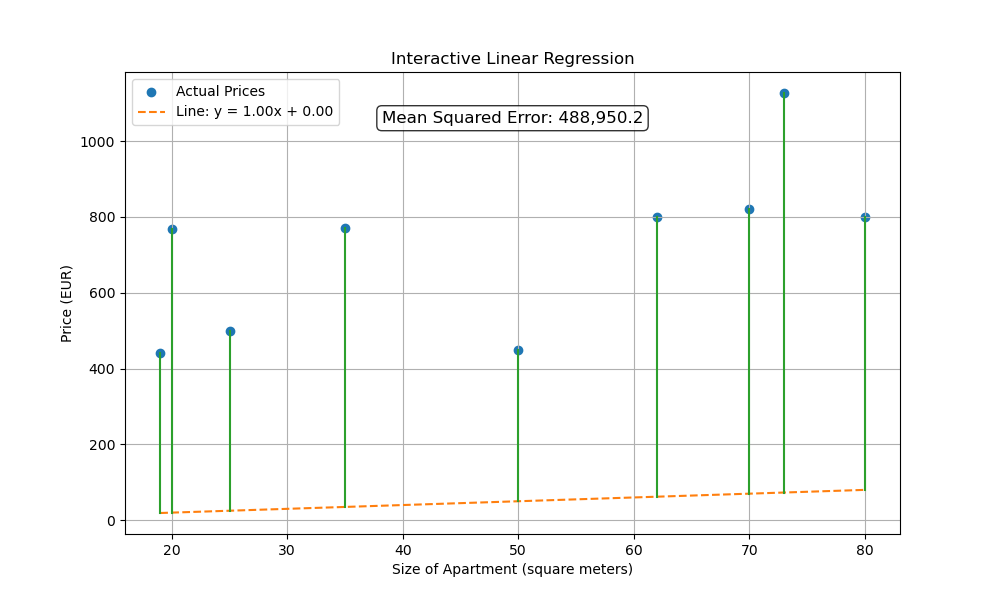

In [28]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

# Function to plot with adjustable slope and intercept
def update_plot(ax, polynomial, quadratic=0, slope=1, intercept=0):
    title = "Interactive Linear Regression"
    legend = lambda _, b, c: f"Line: y = {b:.2f}x + {c:.2f}"
    if polynomial:  # used further below
        title = "Interactive Polynomial Regression"
        legend = lambda a, b, c: f"Line: y = {a:.2f}x^2 + {b:.2f}x + {c:.2f}"

    # Clear the axes but keep the figure
    ax.clear()
    
    # Scatter plot of the actual data
    ax.scatter(sizes, prices, color="C0", label='Actual Prices')
    
    # Line equation: y = slope * x + intercept
    predicted_prices = quadratic * sizes ** 2 + slope * sizes + intercept
    
    # Plot the fitted line with the current quadratic, slope and intercept
    sizes_grid = np.linspace(sizes.min(), sizes.max(), 50)
    predicted_prices_grid = quadratic * sizes_grid ** 2 + slope * sizes_grid + intercept
    ax.plot(sizes_grid, predicted_prices_grid, color="C1", label=legend(quadratic, slope, intercept), linestyle='--')

    # Draw error bars: vertical lines between actual and predicted values - more efficient approach
    error_lines = []
    for i in range(len(sizes)):
        error_lines.extend([[sizes[i], sizes[i]], [prices[i], predicted_prices[i]], [None, None]])
    
    # Plot all error lines at once (more efficient than individual plots)
    x_coords = [error_lines[i] for i in range(0, len(error_lines), 3)]
    y_coords = [error_lines[i] for i in range(1, len(error_lines), 3)]
    
    for x_line, y_line in zip(x_coords, y_coords):
        ax.plot(x_line, y_line, color="C2", linestyle='-', lw=1.5)

    # Calculate and display the mean squared error (MSE)
    mse = mean_squared_error(prices, predicted_prices, verbose=False)
    ax.text(0.5, 0.9, f'Mean Squared Error: {mse:,.1f}', 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontsize=12, color='black',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Labels, title, and legend
    ax.set_title(title)
    ax.set_xlabel('Size of Apartment (square meters)')
    ax.set_ylabel('Price (EUR)')
    ax.legend()
    ax.grid(True)
    
    # Redraw the canvas
    fig.canvas.draw_idle()

%matplotlib widget
plt.close()

# Create persistent figure and axes for better performance
fig, ax = plt.subplots(figsize=(10, 6))

# Interactive widgets for slope and intercept
interact(update_plot, ax=fixed(ax), quadratic=fixed(0), polynomial=fixed(False),
         slope=widgets.FloatSlider(min=-10, max=50, step=0.1, value=1), 
         intercept=widgets.FloatSlider(min=-1000, max=3000, step=50, value=0));


**Task: Fit a line through the first two data points**
- we will start by analytically fitting a straight line using only two data points from our apartment dataset
- this will provide a basic understanding of how linear models estimate relationships between variables
- complete the code below in the `fit` and `predict` method

**Explanation:**
1. `fit`: This method is supposed to train the model. Here, it calculates slope and intercept based on the first two data points.
2. `predict`: This method is expected to provide predictions based on its learned parameters.

In [26]:
class SimpleLinearModel:
    """
    Simple approach fitting a straight line through the first two (of overall n_samples)
    supplied data points (x_0, y_0) and (x_1, y_1).
    """

    def __init__(self):
        self.slope = None
        self.intercept = None

    def fit(self, X, y):
        """
        Fit the model by calculating the straight line running through two (arbitrary) points

        Parameters:
        X : numpy array, shape (n_samples, 1)
            The independent variable (e.g. apartment size).
        y : numpy array, shape (n_samples)
            The dependent variable (e.g. apartment price).
        """
        x1, x2 = X[0, 0], X[1, 0]
        y1, y2 = y[0], y[1]
        self.slope = (y2 - y1) / (x2 - x1)
        self.intercept = y1 - self.slope * x1

    def predict(self, X):
        """
        Predict method for making predictions using the trained model.

        Parameters:
        X : numpy array, shape (n_samples, 1)
            The independent variable(s).

        Returns:
        predictions : numpy array
            Predicted values based on the model's weights.
        """
        return self.slope * X[:, 0] + self.intercept
    
    @staticmethod
    def plot(X, y, predictions):
        sorted_indices = np.argsort(X[:, 0])
        plt.plot(X[sorted_indices], predictions[sorted_indices], color='red', label='Predicted Values')
        plt.scatter(X, y, color='blue', label='Actual Values')
        for x_val, y_true, y_hat in zip(X[:,0], y, predictions):
            plt.plot([x_val, x_val], [y_true, y_hat], color='red', linestyle='--', linewidth=0.8)
        plt.xlabel('Apartment size')
        plt.ylabel('Apartment price')
        plt.title("Simple linear regression")
        plt.legend()
        plt.show()


X = sizes.reshape(-1, 1)
y = prices
model = SimpleLinearModel()
model.fit(X, y)
predictions = model.predict(X)
mean_squared_error(predictions, y)
model.plot(X=X, y=prices, predictions=predictions)

MSE:  128,352.2


ValueError: s must be a scalar, or float array-like with the same size as x and y

## Analytic Solution
The normal equation gives us an analytic solution to the minimization problem $\min_w \lVert Xw - y\rVert^2_2$ where $X\in\mathbb{R}^{m\times d}, w\in\mathbb{R}^d, y\in\mathbb{R}^m$:
$$
w = (X^\intercal X)^{-1}X^\intercal y
$$
where $X^\intercal X$ can be assumed to be invertible with sufficient data.

In [9]:
class AnalyticLinearModel:
    """
    A linear regression model that directly calculates the optimal weights
    using the normal equation (closed-form solution) for multiple input dimensions.
    This model does not provide an intercept term by itself, but instead expects
    the input X to include a bias column as first column (all 1s) if desired.
    """

    def __init__(self):
        self.weights = None  # Weights vector (including bias weight)

    def fit(self, X, y):
        """
        Fit the model by directly calculating the optimal weights using the normal equation.

        Parameters:
        X : numpy array, shape (n_samples, n_features)
            The independent variables with an additional bias column (first column is all 1s).
        y : numpy array, shape (n_samples,)
            The dependent variable (e.g., price of apartments).
        """
        self.weights = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        """
        Predict method for making predictions using the trained model.

        Parameters:
        X : numpy array, shape (n_samples, n_features)
            New data (independent variables with bias term as the first column).

        Returns:
        predictions : numpy array
            Predicted values based on the model's weights.
        """
        return X @ self.weights
    
    def fit_and_plot(self, X, y, title="Linear Regression"):
        """
        Convenience method to both fit and plot.

        Parameters:
        X : numpy array, shape (n_samples, n_features).
            n_features is assumed to be 1, 2 or 3.
            If n_features > 1, it is assumed that the first column is a bias term (all 1s).
            The bias term is not plotted as a proper feature.
        """
        self.fit(X, y)
        predictions = self.predict(X)
        mean_squared_error(predictions, y)
        if X.shape[1] > 1:
            # assume first column is bias term (all 1s) which we do not plot as a proper feature
            X = X[:, 1:]
        assert X.shape[1] in [1, 2], "Can only plot 1D or 2D data (excluding intercept)"
        if X.shape[1] == 1:
            self.plot_1d(X, y, predictions, title=title)
        elif X.shape[1] == 2:
            x1_grid = np.linspace(X[:,0].min(), X[:,0].max(), 50)
            x2_grid = np.linspace(X[:,1].min(), X[:,1].max(), 50)
            x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
            X_grid = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
            if self.weights.shape[0] > X.shape[1]:  # fitted with intercept
                X_grid = np.column_stack((np.ones(X_grid.shape[0]), X_grid))
            predictions_mesh = self.predict(X_grid).reshape(x1_mesh.shape)
            self.plot_2d(X, y, predictions, x1_mesh, x2_mesh, predictions_mesh, title=title)
    
    @staticmethod
    def plot_1d(X, y, predictions, title, x1_mesh=None, predictions_mesh=None):
        if x1_mesh is None or predictions_mesh is None:
            x1_mesh = X
            predictions_mesh = predictions
        sorted_indices = np.argsort(x1_mesh[:, 0])
        plt.plot(x1_mesh[sorted_indices], predictions_mesh[sorted_indices], color='red', label='Predicted Values')
        plt.scatter(X, y, color='blue', label='Actual Values')
        for x_val, y_true, y_hat in zip(X[:,0], y, predictions):
            plt.plot([x_val, x_val], [y_true, y_hat], color='red', linestyle='--', linewidth=0.8)
        plt.xlabel('X values')
        plt.ylabel('y values')
        plt.title(title)
        plt.legend()
        plt.show()

    @staticmethod
    def plot_2d(X, y, predictions, x1_mesh, x2_mesh, predictions_mesh, title):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x1_mesh, x2_mesh, predictions_mesh, color='red', alpha=0.5)
        ax.scatter(X[:,0], X[:,1], y, color='blue')
        ax.scatter(X[:,0], X[:,1], predictions, color='orange')
        for x_val1, x_val2, y_true, y_hat in zip(X[:,0], X[:,1], y, predictions):
            ax.plot([x_val1, x_val1], [x_val2, x_val2], [y_true, y_hat], color='red', linestyle='--', linewidth=0.8)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Target')
        plt.title(title)
        plt.show()

MSE:  62,446.1


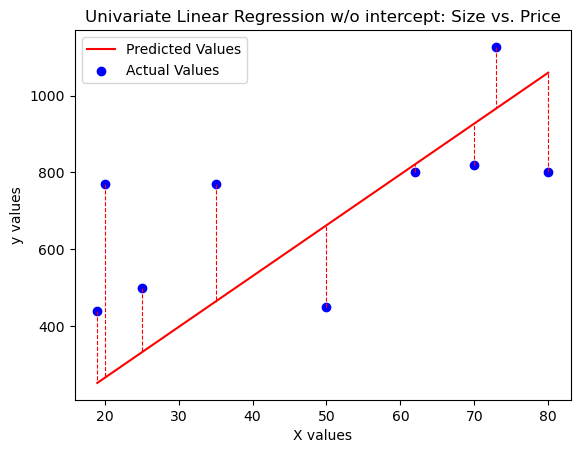

In [7]:
# Univariate Case w/o intercept
%matplotlib inline

plt.close()
X = np.column_stack((sizes, ))
AnalyticLinearModel().fit_and_plot(X, y=prices, title="Univariate Linear Regression w/o intercept: Size vs. Price")

MSE:  26,691.2


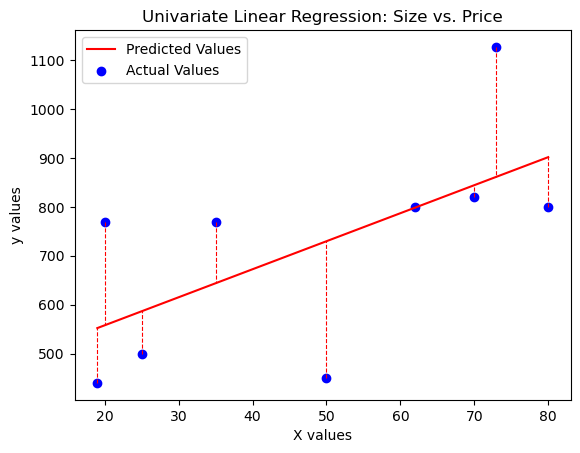

In [8]:
# Univariate Case
%matplotlib inline

plt.close()
X = np.column_stack((np.ones(sizes.shape[0]), sizes))
AnalyticLinearModel().fit_and_plot(X, y=prices, title="Univariate Linear Regression: Size vs. Price")

In [ ]:
# Multivariate Case
%matplotlib widget

plt.close()
X = np.column_stack((np.ones(sizes.shape[0]), sizes, distances))
AnalyticLinearModel().fit_and_plot(X, y=prices, title="Multivariate Linear Regression: Size & Distance vs. Price")

### 3rd Party Model - sklearn

MSE:  26,691.2


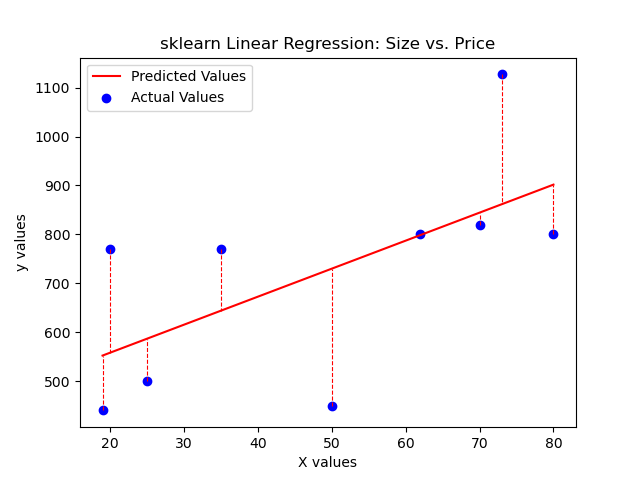

In [10]:
from sklearn.linear_model import LinearRegression

X = np.column_stack((np.ones(sizes.shape[0]), sizes))

sklearn_model = LinearRegression(fit_intercept=False)  # We set fit_intercept to False because we already added a bias column
sklearn_model.fit(X=X, y=prices)
sklearn_predictions = sklearn_model.predict(X=X)
mean_squared_error(prices, sklearn_predictions)

plt.close()
AnalyticLinearModel.plot_1d(X=X[:, 1:], y=prices, predictions=sklearn_predictions, title="sklearn Linear Regression: Size vs. Price")

## Error Surface

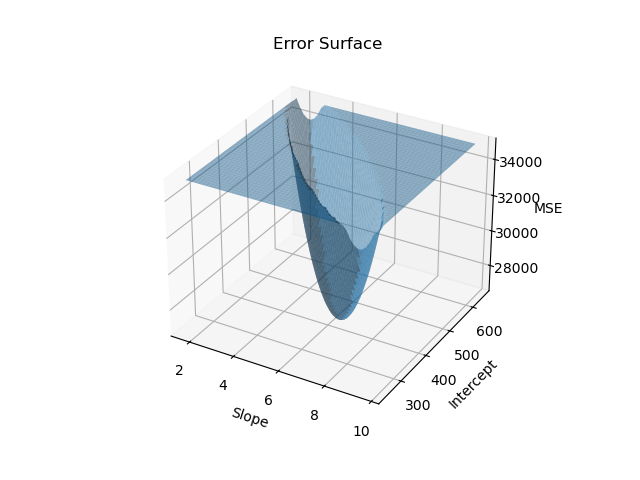

In [39]:
X = np.column_stack((np.ones(sizes.shape), sizes))
errors = []
model = AnalyticLinearModel()
model.fit(X, prices)

precision = 50
slope_grid = np.linspace(model.weights[1] - 4, model.weights[1] + 4, precision)
intercept_grid = np.linspace(model.weights[0] - 200, model.weights[0] + 200, precision)
slope_mesh, intercept_mesh = np.meshgrid(slope_grid, intercept_grid)
mesh = np.c_[slope_mesh.ravel(), intercept_mesh.ravel()]

for slope, intercept in mesh:
    model.weights = np.array([intercept, slope])
    predictions = model.predict(X)
    errors.append(mean_squared_error(prices, predictions, verbose=False))

%matplotlib widget
plt.close()
error_mesh = np.clip(np.array(errors).reshape(slope_mesh.shape), 0, 35_000)  # clip for better visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(slope_mesh, intercept_mesh, error_mesh, alpha=0.5)
ax.set_xlabel("Slope")
ax.set_ylabel("Intercept")
ax.set_zlabel("MSE")
plt.title("Error Surface")
plt.show()

## Polynomial Regression
### Motivation
Univariate case i.e. $x, 1\in\mathbb{R}^{m}$.

Instead of solving $\argmin_w \lVert w_1x + w_0 1 - y\rVert^2_2$ i.e.
$$
\argmin_w \lVert \sum^1_{k=0}w_kx^k - y\rVert^2_2
$$
where $\cdot^k$ is applied element-wise, we extend the model class to polynomials of degree $d$ and solve
$$
\argmin_w \lVert \sum^d_{k=0}w_kx^k - y\rVert^2_2
$$
Note:
- this can be extended to the multivariate case
- by including the polynomial features directly in the data (aka design) matrix $X$ (just like we did with the intercept) we stick to the same optimization target

$$
\argmin_w \lVert Xw - y\rVert^2_2
$$

interactive(children=(FloatSlider(value=0.0, description='quadratic', max=1.0, min=-1.0, step=0.01), FloatSlid…

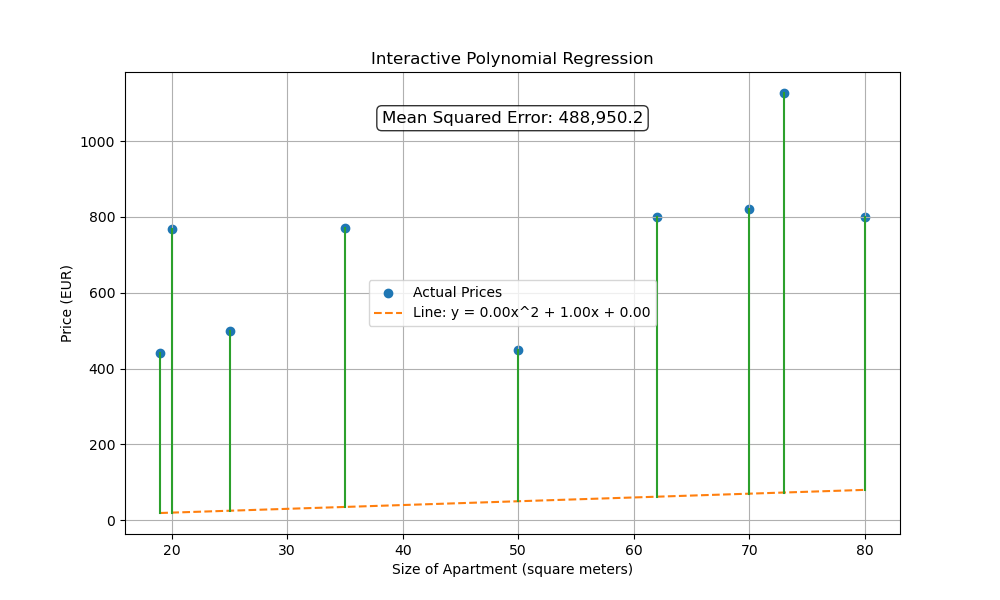

In [17]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

# Function to plot with adjustable slope and intercept
def update_plot(ax, polynomial, quadratic=0, slope=1, intercept=0):
    title = "Interactive Linear Regression"
    legend = lambda _, b, c: f"Line: y = {b:.2f}x + {c:.2f}"
    if polynomial:  # used further below
        title = "Interactive Polynomial Regression"
        legend = lambda a, b, c: f"Line: y = {a:.2f}x^2 + {b:.2f}x + {c:.2f}"

    # Clear the axes but keep the figure
    ax.clear()
    
    # Scatter plot of the actual data
    ax.scatter(sizes, prices, color="C0", label='Actual Prices')
    
    # Line equation: y = slope * x + intercept
    predicted_prices = quadratic * sizes ** 2 + slope * sizes + intercept
    
    # Plot the fitted line with the current quadratic, slope and intercept
    sizes_grid = np.linspace(sizes.min(), sizes.max(), 50)
    predicted_prices_grid = quadratic * sizes_grid ** 2 + slope * sizes_grid + intercept
    ax.plot(sizes_grid, predicted_prices_grid, color="C1", label=legend(quadratic, slope, intercept), linestyle='--')

    # Draw error bars: vertical lines between actual and predicted values - more efficient approach
    error_lines = []
    for i in range(len(sizes)):
        error_lines.extend([[sizes[i], sizes[i]], [prices[i], predicted_prices[i]], [None, None]])
    
    # Plot all error lines at once (more efficient than individual plots)
    x_coords = [error_lines[i] for i in range(0, len(error_lines), 3)]
    y_coords = [error_lines[i] for i in range(1, len(error_lines), 3)]
    
    for x_line, y_line in zip(x_coords, y_coords):
        ax.plot(x_line, y_line, color="C2", linestyle='-', lw=1.5)

    # Calculate and display the mean squared error (MSE)
    mse = mean_squared_error(prices, predicted_prices, verbose=False)
    ax.text(0.5, 0.9, f'Mean Squared Error: {mse:,.1f}', 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontsize=12, color='black',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Labels, title, and legend
    ax.set_title(title)
    ax.set_xlabel('Size of Apartment (square meters)')
    ax.set_ylabel('Price (EUR)')
    ax.legend()
    ax.grid(True)
    
    # Redraw the canvas
    fig.canvas.draw_idle()

%matplotlib widget
plt.close()

# Create persistent figure and axes for better performance
fig, ax = plt.subplots(figsize=(10, 6))

# Interactive widgets for slope and intercept
interact(update_plot, ax=fixed(ax), polynomial=fixed(True),
         quadratic=widgets.FloatSlider(min=-1, max=1, step=0.01, value=0),
         slope=widgets.FloatSlider(min=-80, max=80, step=0.1, value=1), 
         intercept=widgets.FloatSlider(min=-1000, max=3000, step=50, value=0));


### Fitting the Polynomial Model
- the polynomial model is no longer linear in the raw (i.e. before extending with polynomial features) input $X$
- however, it is still linear in its parameters $w$
- hence, the same analytic solution as above can be applied

In [12]:
class AnalyticUnivariatePolynomialModel(AnalyticLinearModel):
    
    def fit_and_plot(self, X, y, slope_index=1, title="Univariate Polynomial Regression"):
        """
        Parameters:
        slope_index : int, index of the x^1 feature column
                        The only feature that is actually plotted.
                        Any other feature can be computed from this feature.

        """
        self.fit(X, y)
        predictions = self.predict(X)
        mean_squared_error(predictions, y)
        x1_mesh = np.linspace(X[:, slope_index].min(), X[:, slope_index].max(), 50)
        X_mesh = np.column_stack([x1_mesh**k for k in range(X.shape[1])])
        predictions_mesh = self.predict(X_mesh)
        self.plot_1d(
            X[:, slope_index : slope_index + 1],
            y,
            predictions,
            x1_mesh=X_mesh[:, slope_index : slope_index + 1],
            predictions_mesh=predictions_mesh,
            title=title
        )

MSE:  25,592.8


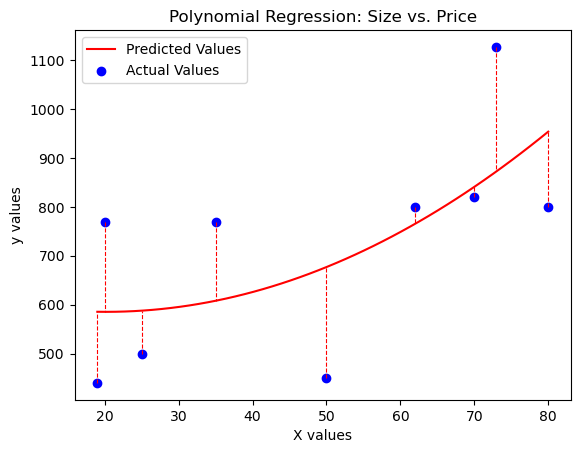

In [13]:
# Univariate Polynomial
%matplotlib inline

# Provide polynomial features
degree = 2
X = np.column_stack([sizes**k for k in range(degree + 1)])

plt.close()
AnalyticUnivariatePolynomialModel().fit_and_plot(X, y=prices, title="Polynomial Regression: Size vs. Price")

MSE:  25,592.8


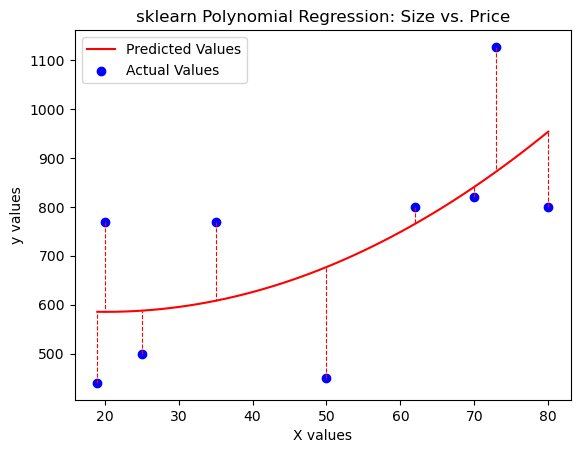

In [ ]:
# 3rd Party Model - sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Provide polynomial features
degree = 2
# X = np.column_stack([sizes**k for k in range(degree + 1)])
X = PolynomialFeatures(degree=degree).fit_transform(sizes.reshape(-1, 1)) # note how we use sklearn to generate polynomial features

# Fit the sklearn model
sklearn_model = LinearRegression(fit_intercept=False)  # We set fit_intercept to False because we already added a bias column
sklearn_model.fit(X=X, y=prices)
sklearn_predictions = sklearn_model.predict(X=X)

# Predictions on a meshgrid for plotting
slope_index = 1
slope_mesh = np.linspace(X[:, slope_index].min(), X[:, slope_index].max(), 50)
X_mesh = np.column_stack([slope_mesh**k for k in range(X.shape[1])])
predictions_mesh = sklearn_model.predict(X_mesh)

# Output
mean_squared_error(prices, sklearn_predictions)
%matplotlib inline
plt.close()
AnalyticUnivariatePolynomialModel.plot_1d(
    X[:, slope_index].reshape(-1, 1),
    prices,
    sklearn_predictions,
    x1_mesh=X_mesh[:, slope_index].reshape(-1, 1),
    predictions_mesh=predictions_mesh,
    title="sklearn Polynomial Regression: Size vs. Price"
)

**Task: Optimize hyper-parameters of polynomial regression**
1. Find the polynomial degree and the univariate regressor (*sizes* or *rooms* or *distances*) that achieve the best minimal MSE
2. Can you achieve zero MSE?
3. Do you want a model that achieves zero MSE?
4. Which results do you achieve when combining multiple regressors?

**Solution**
1. Optimal univariate polynomial regression hyper-parameters: *sizes* as regressor and polynomial model of degree $6$ achieves 13,777.5 MSE
2. Analytic solution diverges numerically before reaching zero MSE (there exist numerically more stable variants for `np.linalg.inv`, though)
3. In general, I want a model that predicts new data well; achieving zero MSE on training data is a sign for overfitting and bad performance on new data
4. Combining multiple regressors reaches zero MSE (due to the diversity of features already for numerically stable small degrees)

In [15]:
minimal_mse = None
for features_name, features in [("sizes", sizes), ("rooms", rooms), ("distances", distances)]:
    for degree in range(10):
        X = PolynomialFeatures(degree=degree).fit_transform(np.column_stack((features,)))
        sklearn_model = LinearRegression(fit_intercept=False)
        sklearn_model.fit(X=X, y=prices)
        sklearn_predictions = sklearn_model.predict(X=X)
        mse = mean_squared_error(prices, sklearn_predictions, verbose=False)
        if minimal_mse is None or mse < minimal_mse:
            minimal_mse = mse
            params = features_name, degree, sklearn_model.coef_

print(f"{minimal_mse:,.1f}")
print(params)

13,777.5
('sizes', 6, array([ 1.23929080e+04, -1.82815266e+03,  1.09173700e+02, -3.21158557e+00,
        4.92824984e-02, -3.75938900e-04,  1.11981817e-06]))


## Final Remarks on Analytic Solution

* Efficient for Small Data: This approach works well for small datasets
* But: computing the inverse can be computationally expensive for large datasets


<div style="text-align: right;">
<i>This notebook has been created with the help of ChatGPT-4, 15.10.2024; Explanations were initially generated and afterwards edited;</i>
</div>